In [6]:
# debug options

steps=1000
learning_rate = 0.005
expected_cost = 0.01

In [7]:
# make cpu stats data

import random

NR_SAMPLES_PER_HOUR = 6
# 10 minutes
MINUTES_BETWEEN_SAMPLES = 60 / NR_SAMPLES_PER_HOUR

def get_cpu_stats():
    def create_stats_list(start, stop, hours):
        # 0.0 ~ 1.0 -> 0% ~ 100%
        return [random.randrange(start, stop) / 100.0 for i in range(len(hours) * NR_SAMPLES_PER_HOUR)]
    stats = []
    hours = range(0, 5)
    stats.extend(create_stats_list(5, 20, hours))
    hours = range(5, 19)
    stats.extend(create_stats_list(0, 100, hours))
    hours = range(19, 24)
    stats.extend(create_stats_list(5, 20, hours))
    return stats

def transform_list(L):
    length = len(L)
    return [float(i)/(length - 1) for i in L]

In [8]:
import numpy as np
import tensorflow as tf


stats = get_cpu_stats()

train_x = np.array(transform_list(range(len(stats))))
train_y = np.array(stats)

w = tf.Variable(tf.random_uniform([1]))
b = tf.Variable(tf.zeros([1]))
y = w * train_x + b

cost = tf.reduce_mean(tf.square(y - train_y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

train = optimizer.minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(steps):
    sess.run(train)
    curr_cost = sess.run(cost)
    if i % 100 == 0:
        print 'step %-5d: cost %.16f' % (i, curr_cost)
    if curr_cost < expected_cost:
        print 'step %-5d: cost %.16f <-- OK' % (i, curr_cost)
        break

curr_w = sess.run(w)
curr_b = sess.run(b)

print 'Train done: w=%f, b=%f' % (curr_w, curr_b)

step 0    : cost 0.1556265503168106
step 100  : cost 0.0919577255845070
step 200  : cost 0.0864224433898926
step 300  : cost 0.0854892432689667
step 400  : cost 0.0849773213267326
step 500  : cost 0.0845530629158020
step 600  : cost 0.0841836109757423
step 700  : cost 0.0838604271411896
step 800  : cost 0.0835775956511497
step 900  : cost 0.0833300724625587
Train done: w=0.092319, b=0.274780


In [9]:
def y_fn(x):
    # y = w*x + b
    return x * curr_w + curr_b

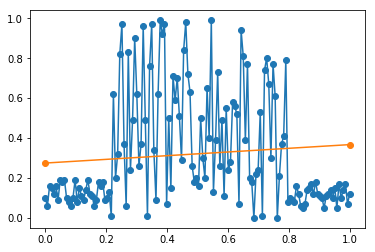

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline  

x = np.array(train_x)
y = np.array(train_y)

line_x = [0.0, 1.0]
line_y = [y_fn(0.0), y_fn(1.0)]

#print x
#print y
#print line_x
#print line_y

plt.plot(x, y, line_x, line_y, marker = 'o')

plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0
 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


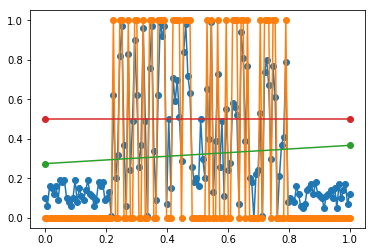

In [13]:
x = np.array(train_x)
y = np.array(train_y)

force_idle_threshold = 0.5 # 50%
# busy: 1, idle: 0
y2 = np.array([1 if i > y_fn(i) and i > force_idle_threshold else 0 for i in train_y])

print y2

threshold_x = [0.0, 1.0]
threshold_y = [force_idle_threshold, force_idle_threshold]

plt.plot(x, y, x, y2, line_x, line_y, threshold_x, threshold_y, marker = 'o')
plt.show()

In [12]:
def collect_idle_time_windows(stats):
    time_windows = {}
    nr_idle = 0
    for index, value in enumerate(stats):
        if value == 0:
            nr_idle += 1
        else:
            if nr_idle > 0:
                # key: start sample index
                # value: number of idle samples
                time_windows[index - nr_idle] = nr_idle
                nr_idle = 0
    else:
        if nr_idle > 0:
            time_windows[index - nr_idle] = nr_idle
    # sort by value from max to min
    # returns: [(k1,v1), (k2,v2), ...]
    return sorted(time_windows.items(), key=lambda item: item[1], reverse=True)


def show_idle_time_windows(idle_time_window):
    print("\nidle time windows details:")
    for t in idle_time_window:
        start_hour = int(t[0] / NR_SAMPLES_PER_HOUR)
        start_minute = (t[0] % NR_SAMPLES_PER_HOUR) * MINUTES_BETWEEN_SAMPLES
        end_hour = int((t[0] + t[1]) / NR_SAMPLES_PER_HOUR)
        end_minute = ((t[0] + t[1]) % NR_SAMPLES_PER_HOUR) * MINUTES_BETWEEN_SAMPLES
        print("{:>02d}:{:>02d} ~ {:>02d}:{:>02d} -> {:<3d} minutes".format(start_hour, start_minute, end_hour, end_minute, MINUTES_BETWEEN_SAMPLES * t[1]))
        


time_windows = collect_idle_time_windows(y2)
print 'idle time windows:', time_windows

show_idle_time_windows(time_windows)

idle time windows: [(0, 32), (113, 30), (69, 7), (96, 5), (109, 4), (82, 3), (57, 3), (33, 2), (37, 2), (40, 2), (44, 2), (47, 2), (51, 2), (86, 2), (79, 2), (91, 1), (102, 1), (64, 1), (106, 1), (77, 1), (94, 1)]

idle time windows details:
00:00 ~ 05:20 -> 320 minutes
18:50 ~ 23:50 -> 300 minutes
11:30 ~ 12:40 -> 70  minutes
16:00 ~ 16:50 -> 50  minutes
18:10 ~ 18:50 -> 40  minutes
13:40 ~ 14:10 -> 30  minutes
09:30 ~ 10:00 -> 30  minutes
05:30 ~ 05:50 -> 20  minutes
06:10 ~ 06:30 -> 20  minutes
06:40 ~ 07:00 -> 20  minutes
07:20 ~ 07:40 -> 20  minutes
07:50 ~ 08:10 -> 20  minutes
08:30 ~ 08:50 -> 20  minutes
14:20 ~ 14:40 -> 20  minutes
13:10 ~ 13:30 -> 20  minutes
15:10 ~ 15:20 -> 10  minutes
17:00 ~ 17:10 -> 10  minutes
10:40 ~ 10:50 -> 10  minutes
17:40 ~ 17:50 -> 10  minutes
12:50 ~ 13:00 -> 10  minutes
15:40 ~ 15:50 -> 10  minutes
